In [2]:
from io import StringIO
from SPARQLWrapper import SPARQLWrapper, CSV
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.model_selection import train_test_split
import warnings
import itertools
from pylab import rcParams
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import itertools
import sys

In [3]:
sparql = SPARQLWrapper("endpoint_url")
sparql.setCredentials('user', 'password')

## 1. Get Number of views

In [4]:
sparql.setQuery("""
SELECT (SUM(?numclick) AS ?count_viewed) ?timecreated
WHERE
  { ?x e-lion:logEduLevel ?edulevel. FILTER (?edulevel = 2)
    ?x e-lion:logTimeCreated ?timecreated.
    ?x e-lion:recordCourse ?course.
    ?x e-lion:logSumClick ?numclick.
    ?course e-lion:courseSource ?coursesource. FILTER(?coursesource = "Open University")
}GROUP BY ?timecreated
""")

In [5]:
sparql.setReturnFormat(CSV)
results_log_view = sparql.query().convert()
s=str(results_log_view,'utf-8')
data = StringIO(s)

In [6]:
results_log_count_view_ou = pd.read_csv(data)
results_log_count_view_ou.head()

,count_viewed,timecreated
0,4975,2015-06-06T00:00:00
1,4015,2015-06-07T00:00:00
2,3636,2015-06-08T00:00:00
3,2690,2015-06-09T00:00:00
4,1838,2015-06-10T00:00:00


## 2. Group views by weekly frequency

In [7]:
results_log_count_view_ou['Date'] = pd.to_datetime(results_log_count_view_ou['timecreated'])
results_log_count_view_group_ou = results_log_count_view_ou[['count_viewed', 'Date']]
res_views_ou = results_log_count_view_group_ou.groupby([pd.Grouper(key='Date', freq='W-MON')])['count_viewed'].sum()
res_views_ou.head()
res_views_ou=res_views_ou.tail(-1)
res_views_ou=res_views_ou.head(-4)

#### Plot views time series

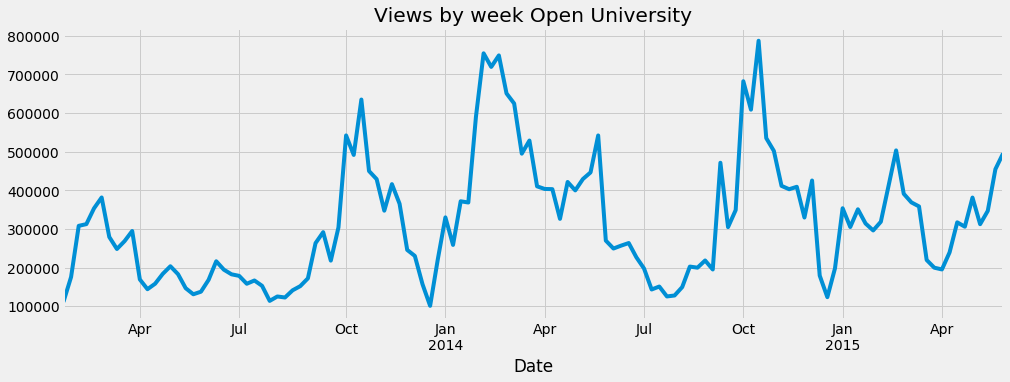

In [8]:
res_views_ou.plot(x='Date', y='count_viewed', figsize = (15,5), title = 'Views by week Open University')
plt.show()

## 3. Split data into train and test

In [9]:
y_train, test_data = train_test_split(res_views_ou, train_size=0.85)

In [10]:
test_data

Date
2015-01-26    314167
2015-02-02    296197
2015-02-09    318639
2015-02-16    410547
2015-02-23    503327
2015-03-02    391004
2015-03-09    368767
2015-03-16    358328
2015-03-23    219766
2015-03-30    199819
2015-04-06    195273
2015-04-13    239385
2015-04-20    317180
2015-04-27    305857
2015-05-04    381258
2015-05-11    312342
2015-05-18    346818
2015-05-25    454718
2015-06-01    495208
Freq: W-MON, Name: count_viewed, dtype: int64

## 4. Test stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller
print(" > Is the data stationary ?")
dftest = adfuller(res_views_ou)
print('ADF Statistic: %3f' % dftest[0])
print('p-value: %3f' % dftest[1])
print('Critical Values:')
for k, v in dftest[4].items():
    print('\t%s: %.3f' % (k, v))

 > Is the data stationary ?
ADF Statistic: -3.226545
p-value: 0.018499
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


In [12]:
#  Dicker-Fuller
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(window=16,center=True).mean()
    rolstd = timeseries.rolling(window=16,center=True).std()
    # rolling statistics plot
    plt.figure(figsize=(40,10))
    orig = plt.plot(timeseries, color='blue',label='Time Series')
    mean = plt.plot(rolmean, color='red', label='Mean rolling')
    std = plt.plot(rolstd, color='black', label = 'Std. rolling')
    plt.legend(loc='best')
    plt.title('Time series with rolling mean and std')
    plt.show(block=False)
    # Dicket-Fuller test
    dftest = adfuller(timeseries.values, autolag='AIC')
    tstat = dftest[0]; pvalue = dftest[1]; cvalues = dftest[4]
    print('Dickey-Fuller Results')
    print("------------------")
    print("Test statistic\t",tstat)
    print("p-value\t\t\t",pvalue)
    print("------------------")
    print("Critical values (The test statistic should be lower)")
    for clevel in [10,5,1]:
        conf = 100-clevel
        cval = cvalues['%i%%' % clevel]
        if tstat < cval:
            comp = ">"
            verdict = "Pass"
        else:
            comp = "<"
            verdict = "Fails"
        print("Confidence %i%%\t\t%f %s %f ... %s" % (conf, cval, comp, tstat, verdict))

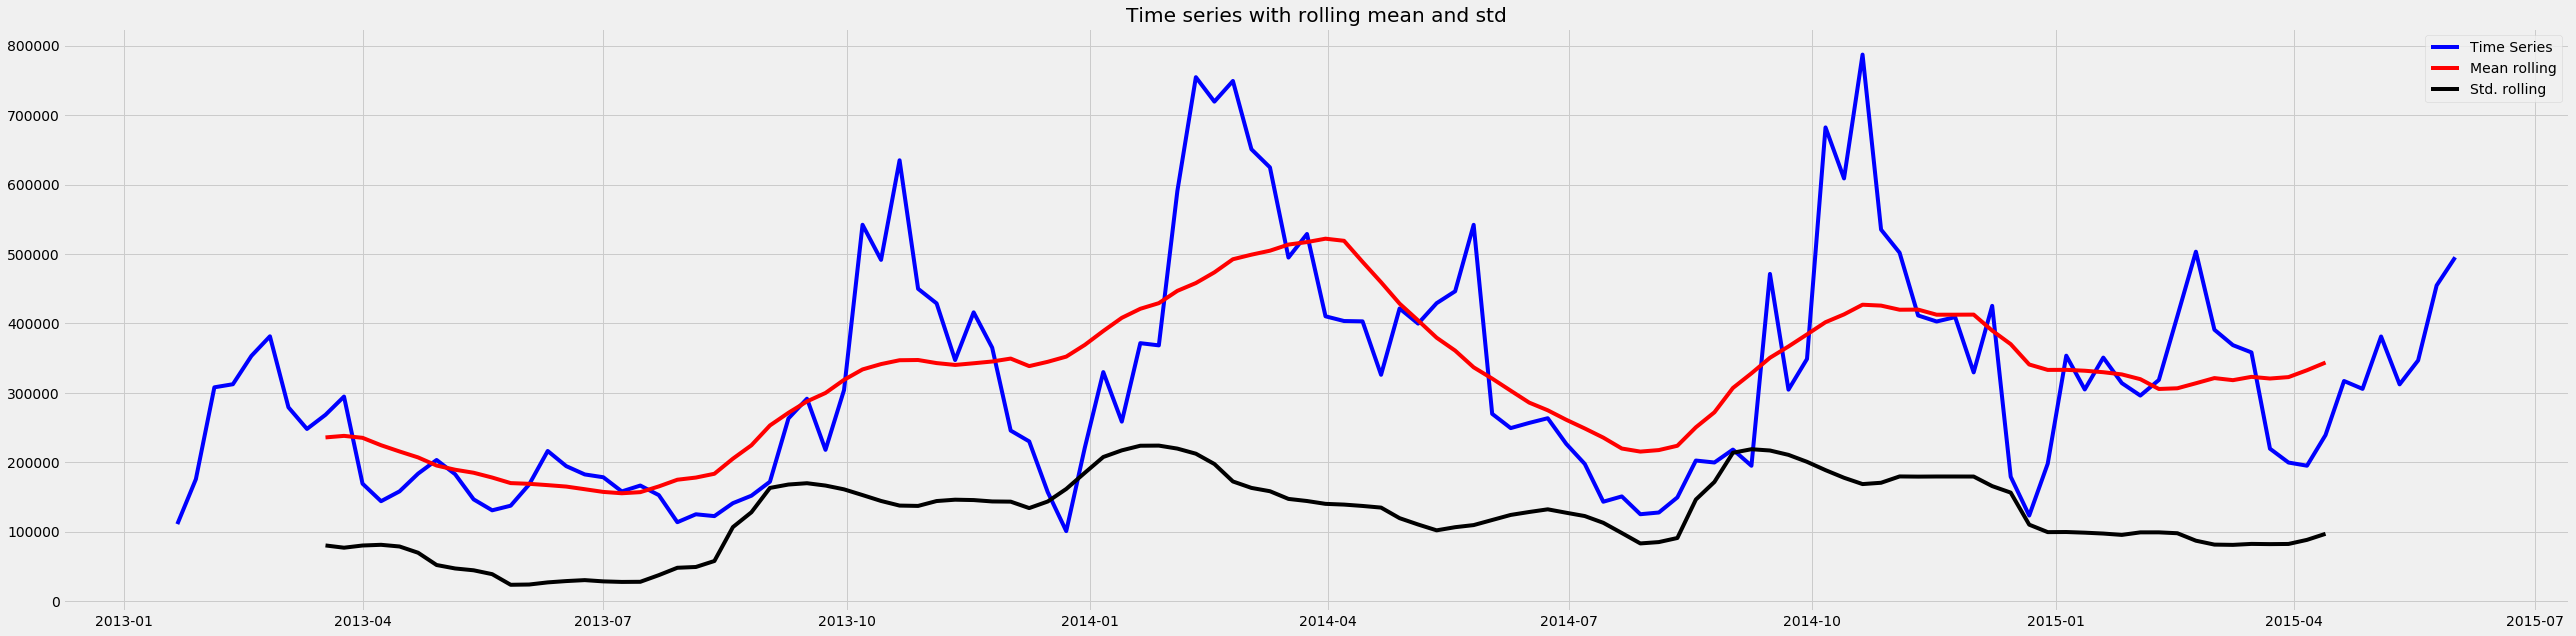

Dickey-Fuller Results
------------------
Test statistic	 -3.2265449023213506
p-value			 0.01849866316589928
------------------
Critical values (The test statistic should be lower)
Confidence 90%		-2.579676 > -3.226545 ... Pass
Confidence 95%		-2.885739 > -3.226545 ... Pass
Confidence 99%		-3.485585 < -3.226545 ... Fails


In [13]:
test_stationarity(res_views_ou)

## 5. Seasonal decompose

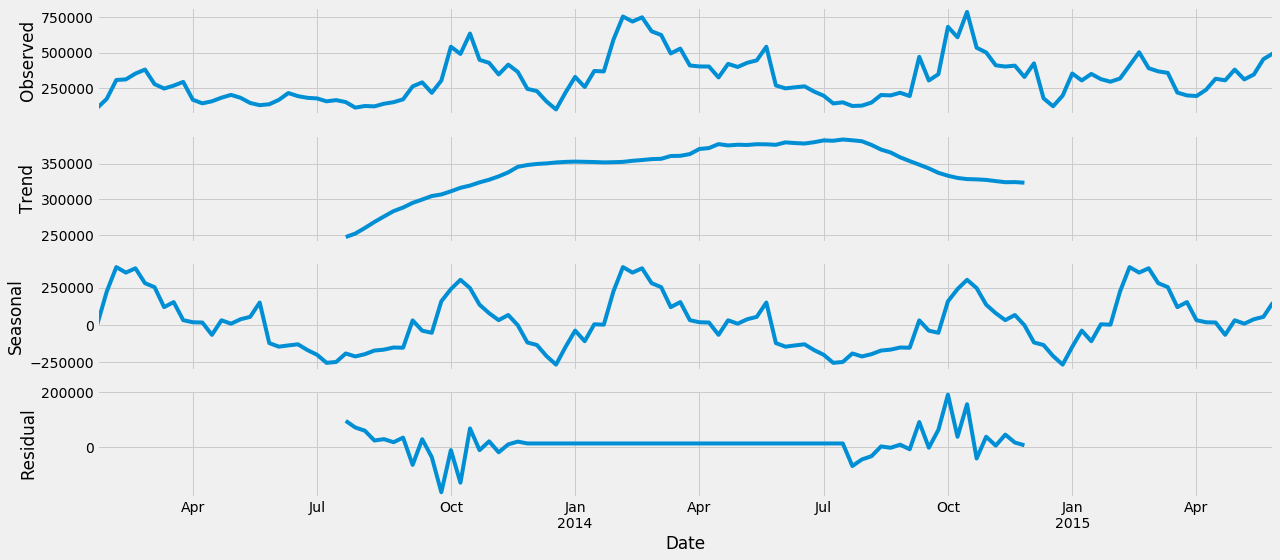

In [14]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(res_views_ou, model='additive', freq=53)
fig = decomposition.plot()
plt.show()

## 6. SARIMAX model

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 53) for x in list(itertools.product(p, d, q))]

In [16]:
best_result=sys.maxsize
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(res_views_ou,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_result:
                best_result=results.aic
                best_conf = results
                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 53) - AIC:3496.0017736681784
SARIMAX(0, 0, 0)x(0, 1, 0, 53) - AIC:1923.118993939031
SARIMAX(0, 0, 0)x(1, 1, 0, 53) - AIC:472.8630873490967
SARIMAX(0, 1, 0)x(1, 1, 0, 53) - AIC:434.96958197829235
SARIMAX(1, 1, 0)x(1, 1, 0, 53) - AIC:412.54672432097277


In [17]:
print(best_conf.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       count_viewed   No. Observations:                  124
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 53)   Log Likelihood                -203.273
Date:                            Tue, 15 Jun 2021   AIC                            412.547
Time:                                    08:34:38   BIC                            414.864
Sample:                                01-21-2013   HQIC                           412.665
                                     - 06-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0712      0.441     -0.161      0.872      -0.935       0.793
ar.S.L53      -0.2611      0.598   

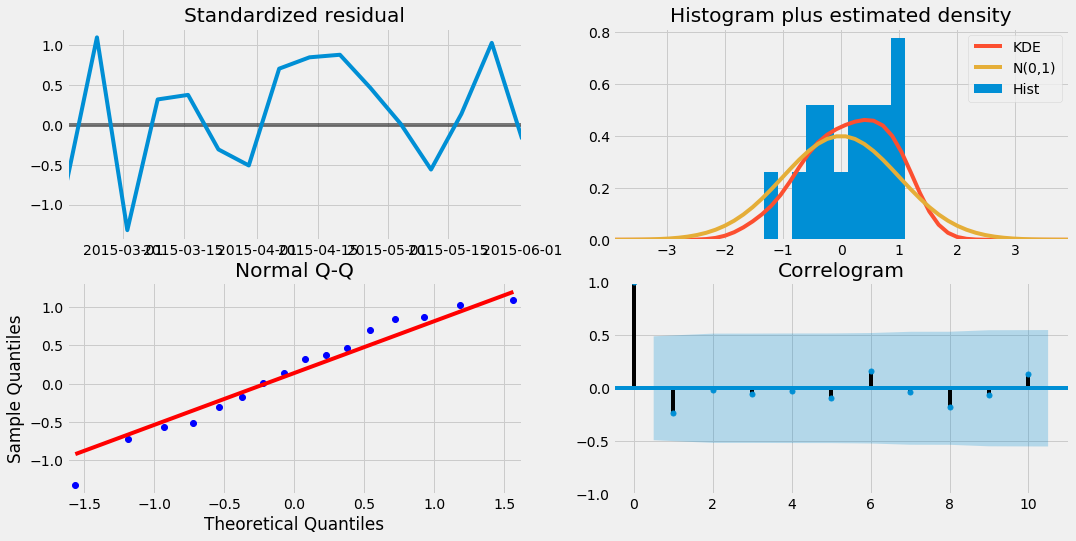

In [18]:
best_conf.plot_diagnostics(figsize=(16, 8))
plt.show()

## 7. Forecast

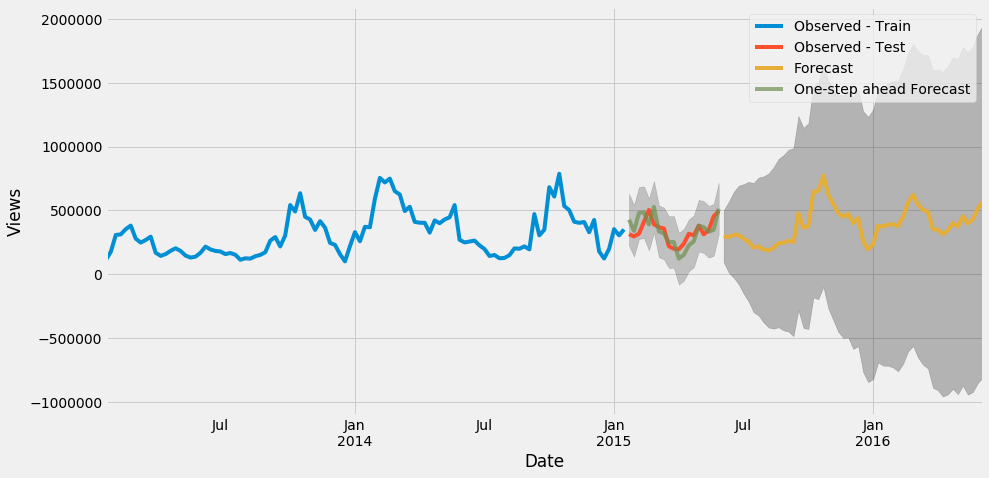

In [19]:
pred_forecast = best_conf.get_forecast(steps=53)
pred_ci1 = pred_forecast.conf_int()
ax = y_train.plot(label='Observed - Train', figsize=(14, 7))
ax = test_data.plot(label='Observed - Test')
pred_forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci1.index,
                pred_ci1.iloc[:, 0],
                pred_ci1.iloc[:, 1], color='k', alpha=.25)

pred = best_conf.get_prediction(start=pd.to_datetime(test_data.index[0]), dynamic=False)
pred_ci2 = pred.conf_int()
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Views')
plt.legend()
plt.show()

In [20]:
y_forecasted = pred.predicted_mean
mae = mean_absolute_error(test_data, y_forecasted)
mse = mean_squared_error(test_data, y_forecasted)
rmse = mean_squared_error(test_data, y_forecasted, squared=False)
mlse = mean_squared_log_error(test_data, y_forecasted)

print('The Mean Absolute of our forecasts is: {}'.format(round(mae, 2)))
print('The Mean Squared Error of our forecasts is: {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is: {}'.format(round(rmse, 2)))
print('Mean squared logarithmic error of our forecasts is: {}'.format(round(mlse, 2)))

The Mean Absolute of our forecasts is: 68136.98
The Mean Squared Error of our forecasts is: 6452150466.42
The Root Mean Squared Error of our forecasts is: 80325.28
Mean squared logarithmic error of our forecasts is: 0.06


In [21]:
print(res_views_ou.mean())

318577.93548387097
